### 0. 설치 라이브러리

In [18]:
# !pip install opencv-python
# !pip install gym[all,accept-rom-license]
# !pip install swig
# !pip install --upgrade pip setuptools wheel
# !pip install --upgrade gym
# !pip install tqdm
# !pip install gym[box2d]
# !pip install pyvirtualdisplay moviepy
# !pip install pandas

### 1. 실험환경 설정

##### 1-1 GPU 확인

In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# GPU를 사용할 수 있는지 확인
if torch.cuda.is_available():
    # 사용 가능한 GPU 디바이스 개수 확인
    num_gpu = torch.cuda.device_count()
    print(f"사용 가능한 GPU 수: {num_gpu}")

    # 현재 선택된 GPU 디바이스 확인
    current_gpu = torch.cuda.current_device()   

    # 사용 가능한 GPU 디바이스 목록 확인
    for i in range(num_gpu):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU를 사용할 수 없습니다.")

cuda
사용 가능한 GPU 수: 1
GPU 0: GeForce GTX 1060 6GB


##### 1-2 라이브러리 import

In [20]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
import pandas as pd
import time

##### 1-3. environment 확인

In [21]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(f"state_size : {state_size}, action_size : {action_size}")

state_size : 8, action_size : 4


##### 1-4. seed number 세팅

In [22]:
seed = 30   # 23, 30, 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 2. 세부 구조 설계

 ##### 2-1 Policy network 설계

In [ ]:
n_hidden_units = 2   # hidden layer 층 : 1 / 2 / 3 / 4 / 5
hidden_units = 32    # hidden layer node수 : 32 / 64 / 128

In [24]:
class Qnet(nn.Module):

    def __init__(self, n_states, n_actions, 
                 n_hidden_units=n_hidden_units, 
                 hidden_units=hidden_units):
        
        super(Qnet, self).__init__()

        # Define the number of hidden layers
        self.hidden_layers = nn.ModuleList()
        prev_layer_units = n_states

        for _ in range(n_hidden_units):
            self.hidden_layers.append(nn.Linear(prev_layer_units, hidden_units))
            prev_layer_units = hidden_units

        self.output_layer = nn.Linear(prev_layer_units, n_actions)

    def forward(self, x):
        # Forward pass through hidden layers
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        # Forward pass through output layer
        x = self.output_layer(x)
        return x


In [25]:
qnet_model = Qnet(state_size, action_size, n_hidden_units, hidden_units)
print(qnet_model)

Qnet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=4, bias=True)
)


##### 2-2 DQN / DDQN 설계 - learn 부분 일부만 수정하면 됨(주석처리)

In [26]:
class DDQN:
    def __init__(self, n_states, n_actions, batch_size, lr, gamma, memory_size, learn_step, tau, device=None):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 가장 좋은 모델 저장을 위한 변수
        self.best_score = float('-inf')  # 초기화: 음수 무한대

        # 모델
        self.net_eval = Qnet(n_states, n_actions).to(device)
        self.net_target = Qnet(n_states, n_actions).to(device)
        self.optimizer = optim.AdamW(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # 메모리
        self.memory = ReplayBuffer(n_actions, memory_size, batch_size)
        self.counter = 0    # 업데이트 주기 카운터

        # 에피소드당 평균 보상을 기록할 리스트 초기화
        self.avg_score_hist = []

        # 총 보상을 기록할 리스트 초기화
        self.score_hist = []

    def sample_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.net_eval.eval()
        coin = random.random()

        with torch.no_grad():
            action_values_eval = self.net_eval(state)

        if coin < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            # Use net_eval for action selection and net_target for action evaluation
            action = np.argmax(self.net_target(state).cpu().data.numpy())

        self.net_eval.train()
        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.put(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # ################ DQN ################        
        # q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        # #####################################

        ################ DDQN ###############
        argmax_Q_next = self.net_eval(next_states).max(1)[1].unsqueeze(1)
        q_target_next = self.net_target(next_states).gather(1, argmax_Q_next)
        q_target = q_target_next.detach().max(axis=1)[0].unsqueeze(1)
        #####################################

        y_j = rewards + self.gamma * q_target * (1 - dones) 
        
        actions = actions.to(torch.int64)
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.soft_update()

    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def train(self, env, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, chkpt=False):
        epsilon = eps_start

        start_time = time.time()  # 훈련 시작 시간 기록

        # Calculate decay factor based on the given eps_decay and number of episodes
        decay_factor = np.exp(np.log(eps_end / eps_start) / n_episodes)

        for idx_epi in tqdm(range(n_episodes), unit="ep", ascii=True):
            state = env.reset()[0]
            score = 0

            for idx_step in range(max_steps):
                action = self.sample_action(state, epsilon)
                next_state, reward, done, _, _ = env.step(action)
                self.save2memory(state, action, reward, next_state, done)
                state = next_state
                score += reward

                if done:
                    break

            experiences = self.memory.sample()
            self.learn(experiences)

            self.score_hist.append(score)
            score_avg = np.mean(self.score_hist[-100:])
            epsilon = max(eps_end, epsilon * decay_factor)  # Update epsilon using decay factor

            self.avg_score_hist.append(score_avg)

            if (idx_epi + 1) % 50 == 0:
                elapsed_time = time.time() - start_time  # 현재까지 걸린 시간 계산
                print(f"Episode {idx_epi + 1}, Score: {score:.3f}, Avg Score (last 100): {score_avg:.3f}, Epsilon: {epsilon:.3f}, Elapsed Time: {elapsed_time:.2f} seconds")

                if score > self.best_score:
                    self.best_score = score
                    print("====Saving the best model====")
                    #torch.save(self.net_eval.state_dict(), 'best_model_DDQN_1_layer_seed23.pth')                    
                    print(f"Episode {idx_epi + 1}, Score: {score:.3f}, Avg Score (last 100): {score_avg:.3f}, Epsilon: {epsilon:.3f}, Elapsed Time: {elapsed_time:.2f} seconds")

                    model_save_path = f'best_model_DDQN_{n_hidden_units}layer_seed{seed}.pth'
                    torch.save(self.net_eval.state_dict(), model_save_path)

        if idx_epi == n_episodes - 1:
            print("\nDone!")

        self.save_scores_to_csv()

        return self.score_hist, self.avg_score_hist


    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def load_model(self, path):
        self.net_eval.load_state_dict(torch.load(path))
        self.net_eval.eval()

    def save_scores_to_csv(self, filename=f'DDQN_{n_hidden_units}layer_seed{seed}.csv'):
        df = pd.DataFrame({'Episode': np.arange(1, len(self.score_hist) + 1), 'Score': self.score_hist, 'Avg_Score': self.avg_score_hist})
        df.to_csv(filename, index=False)

 ##### 2-3 ReplayBuffer 설계

In [27]:
class ReplayBuffer:
    def __init__(self, n_actions, memory_size, batch_size, device=None):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = collections.deque(maxlen=memory_size)

    def put(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.memory.append(transition)

    def sample(self):
        mini_batch = random.sample(self.memory, self.batch_size)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return (
            torch.tensor(s_lst, dtype=torch.float, device=self.device),
            torch.tensor(a_lst, device=self.device),
            torch.tensor(r_lst, dtype=torch.float, device=self.device),
            torch.tensor(s_prime_lst, dtype=torch.float, device=self.device),
            torch.tensor(done_mask_lst, dtype=torch.float, device=self.device)
        )

    def __len__(self):
        return len(self.memory)

### 3. 시각화

##### 3-1 plot함수 정의

In [28]:
def plot_score(scores, moving_avg_scores, save_path=None):
    plt.figure(figsize=(15, 4))
    
    # Plot Episode Score
    plt.plot(scores, label='Episode Score')
    
    # Plot Moving Average Score
    plt.plot(moving_avg_scores, label='Moving Average Score', color='r', linestyle='--')

    # Plot Overall Mean Score
    overall_mean_score = np.mean(scores)
    plt.axhline(y=overall_mean_score, color='g', linestyle='-.', label=f'Overall Mean Score: {overall_mean_score:.2f}')

    # Find and Plot Maximum Score
    max_score = np.max(scores)
    plt.scatter(np.argmax(scores), max_score, color='m', label=f'Max Score: {max_score:.2f}', marker='o', s=100)

    # Plot Standard Deviation
    std_dev_score = np.std(moving_avg_scores)
    plt.title(f"Scores Over Episodes - Standard Deviation: {std_dev_score:.2f}")

    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()

    # Save the plot to an image file if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    # Show the plot (either in a window or saved file)
    plt.show()



### 4. 실험환경 설정

##### 4-1 하이퍼퍼라미터 설정

In [29]:
batch_size = 32
lr = 1e-3
episode = 10000
gamma = 0.999            # discount factor
memory_size = 10000     # max memory buffer size
learn_step = 5          # how often to learn
tau = 1e-4              # for soft update of target parameters
print(device)

cuda


##### 4-2 MLP구조 확인

In [31]:
print(f" node # : {hidden_units},  layer # : {n_hidden_units}, seed # : {seed}")

 node # : 32,  layer # : 2, seed # : 30


##### 4-3 Train

In [15]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

agent = DDQN(
    n_states=num_states,
    n_actions=num_actions,
    batch_size=batch_size,
    lr=lr,
    gamma=gamma,
    memory_size=memory_size,
    learn_step=learn_step,
    tau=tau,
    device=device
)

score_hist, avg_score_hist = agent.train(env, n_episodes=episode)


  1%|          | 51/10000 [00:08<29:50,  5.56ep/s]

Episode 50, Score: -316.773, Avg Score (last 100): -183.776, Epsilon: 0.977, Elapsed Time: 8.69 seconds
====Saving the best model====
Episode 50, Score: -316.773, Avg Score (last 100): -183.776, Epsilon: 0.977, Elapsed Time: 8.69 seconds


  1%|1         | 101/10000 [00:20<26:13,  6.29ep/s] 

Episode 100, Score: -75.923, Avg Score (last 100): -176.909, Epsilon: 0.955, Elapsed Time: 19.91 seconds
====Saving the best model====
Episode 100, Score: -75.923, Avg Score (last 100): -176.909, Epsilon: 0.955, Elapsed Time: 19.91 seconds


  2%|1         | 151/10000 [00:28<30:20,  5.41ep/s]

Episode 150, Score: -189.014, Avg Score (last 100): -175.550, Epsilon: 0.933, Elapsed Time: 28.46 seconds


  2%|2         | 201/10000 [00:37<28:23,  5.75ep/s]

Episode 200, Score: -111.843, Avg Score (last 100): -183.137, Epsilon: 0.912, Elapsed Time: 37.54 seconds


  3%|2         | 251/10000 [00:46<32:00,  5.08ep/s]

Episode 250, Score: -448.091, Avg Score (last 100): -195.161, Epsilon: 0.891, Elapsed Time: 46.60 seconds


  3%|3         | 300/10000 [00:57<40:50,  3.96ep/s]

Episode 300, Score: -253.757, Avg Score (last 100): -191.842, Epsilon: 0.871, Elapsed Time: 57.08 seconds


  4%|3         | 351/10000 [01:11<35:49,  4.49ep/s]  

Episode 350, Score: -56.684, Avg Score (last 100): -196.701, Epsilon: 0.851, Elapsed Time: 71.65 seconds
====Saving the best model====
Episode 350, Score: -56.684, Avg Score (last 100): -196.701, Epsilon: 0.851, Elapsed Time: 71.65 seconds


  4%|4         | 400/10000 [01:24<35:43,  4.48ep/s]  

Episode 400, Score: -138.445, Avg Score (last 100): -207.082, Epsilon: 0.832, Elapsed Time: 84.49 seconds


  4%|4         | 450/10000 [01:36<37:35,  4.23ep/s]

Episode 450, Score: -117.326, Avg Score (last 100): -209.666, Epsilon: 0.813, Elapsed Time: 96.89 seconds


  5%|5         | 500/10000 [01:52<44:17,  3.57ep/s]  

Episode 500, Score: -166.770, Avg Score (last 100): -209.169, Epsilon: 0.794, Elapsed Time: 112.14 seconds


  6%|5         | 550/10000 [02:04<41:13,  3.82ep/s]

Episode 550, Score: -72.150, Avg Score (last 100): -191.189, Epsilon: 0.776, Elapsed Time: 124.91 seconds


  6%|6         | 600/10000 [02:22<51:50,  3.02ep/s]  

Episode 600, Score: -219.881, Avg Score (last 100): -183.956, Epsilon: 0.759, Elapsed Time: 142.32 seconds


  7%|6         | 651/10000 [02:38<47:14,  3.30ep/s]  

Episode 650, Score: -299.821, Avg Score (last 100): -173.380, Epsilon: 0.741, Elapsed Time: 158.02 seconds


  7%|7         | 700/10000 [02:55<37:14,  4.16ep/s]  

Episode 700, Score: 30.779, Avg Score (last 100): -151.212, Epsilon: 0.724, Elapsed Time: 175.23 seconds
====Saving the best model====
Episode 700, Score: 30.779, Avg Score (last 100): -151.212, Epsilon: 0.724, Elapsed Time: 175.23 seconds


  8%|7         | 750/10000 [03:09<49:28,  3.12ep/s]

Episode 750, Score: -108.230, Avg Score (last 100): -148.519, Epsilon: 0.708, Elapsed Time: 189.14 seconds


  8%|8         | 800/10000 [03:24<45:13,  3.39ep/s]

Episode 800, Score: -104.408, Avg Score (last 100): -157.740, Epsilon: 0.692, Elapsed Time: 204.15 seconds


  8%|8         | 850/10000 [03:38<44:51,  3.40ep/s]

Episode 850, Score: -170.362, Avg Score (last 100): -153.267, Epsilon: 0.676, Elapsed Time: 218.73 seconds


  9%|9         | 900/10000 [03:55<56:27,  2.69ep/s]  

Episode 900, Score: -25.842, Avg Score (last 100): -145.215, Epsilon: 0.661, Elapsed Time: 235.17 seconds


 10%|9         | 950/10000 [04:11<48:48,  3.09ep/s]  

Episode 950, Score: -108.315, Avg Score (last 100): -139.214, Epsilon: 0.646, Elapsed Time: 251.73 seconds


 10%|#         | 1000/10000 [04:31<1:56:55,  1.28ep/s]

Episode 1000, Score: -95.284, Avg Score (last 100): -140.889, Epsilon: 0.631, Elapsed Time: 271.87 seconds


 10%|#         | 1050/10000 [04:48<49:56,  2.99ep/s]  

Episode 1050, Score: -168.741, Avg Score (last 100): -134.879, Epsilon: 0.617, Elapsed Time: 288.16 seconds


 11%|#1        | 1100/10000 [05:05<41:31,  3.57ep/s]  

Episode 1100, Score: -180.211, Avg Score (last 100): -128.888, Epsilon: 0.603, Elapsed Time: 305.05 seconds


 12%|#1        | 1150/10000 [05:28<40:59,  3.60ep/s]  

Episode 1150, Score: -132.482, Avg Score (last 100): -126.210, Epsilon: 0.589, Elapsed Time: 328.79 seconds


 12%|#2        | 1200/10000 [05:51<53:41,  2.73ep/s]  

Episode 1200, Score: -109.998, Avg Score (last 100): -123.765, Epsilon: 0.575, Elapsed Time: 351.01 seconds


 12%|#2        | 1250/10000 [06:10<1:00:37,  2.41ep/s]

Episode 1250, Score: -110.672, Avg Score (last 100): -125.712, Epsilon: 0.562, Elapsed Time: 370.90 seconds


 13%|#3        | 1300/10000 [06:31<1:00:15,  2.41ep/s]

Episode 1300, Score: -48.740, Avg Score (last 100): -118.519, Epsilon: 0.550, Elapsed Time: 391.84 seconds


 14%|#3        | 1350/10000 [06:55<1:33:06,  1.55ep/s]

Episode 1350, Score: -67.547, Avg Score (last 100): -114.784, Epsilon: 0.537, Elapsed Time: 415.23 seconds


 14%|#4        | 1400/10000 [07:13<56:00,  2.56ep/s]  

Episode 1400, Score: -108.628, Avg Score (last 100): -122.895, Epsilon: 0.525, Elapsed Time: 433.41 seconds


 14%|#4        | 1450/10000 [07:32<57:40,  2.47ep/s]  

Episode 1450, Score: -41.618, Avg Score (last 100): -122.366, Epsilon: 0.513, Elapsed Time: 452.53 seconds


 15%|#5        | 1500/10000 [08:02<1:20:07,  1.77ep/s]

Episode 1500, Score: -72.478, Avg Score (last 100): -106.215, Epsilon: 0.501, Elapsed Time: 482.86 seconds


 16%|#5        | 1550/10000 [08:30<1:13:04,  1.93ep/s]

Episode 1550, Score: -34.054, Avg Score (last 100): -92.556, Epsilon: 0.490, Elapsed Time: 510.24 seconds


 16%|#6        | 1600/10000 [09:00<1:11:21,  1.96ep/s]

Episode 1600, Score: -27.050, Avg Score (last 100): -89.951, Epsilon: 0.479, Elapsed Time: 540.12 seconds


 16%|#6        | 1650/10000 [09:25<56:59,  2.44ep/s]  

Episode 1650, Score: -93.984, Avg Score (last 100): -96.129, Epsilon: 0.468, Elapsed Time: 565.54 seconds


 17%|#7        | 1700/10000 [10:01<1:26:23,  1.60ep/s]

Episode 1700, Score: -75.282, Avg Score (last 100): -98.906, Epsilon: 0.457, Elapsed Time: 601.72 seconds


 18%|#7        | 1750/10000 [10:43<2:39:55,  1.16s/ep]

Episode 1750, Score: -215.237, Avg Score (last 100): -95.831, Epsilon: 0.447, Elapsed Time: 643.94 seconds


 18%|#8        | 1800/10000 [11:25<2:31:16,  1.11s/ep]

Episode 1800, Score: -32.421, Avg Score (last 100): -74.853, Epsilon: 0.437, Elapsed Time: 685.25 seconds


 18%|#8        | 1850/10000 [11:55<2:26:04,  1.08s/ep]

Episode 1850, Score: -17.736, Avg Score (last 100): -69.326, Epsilon: 0.427, Elapsed Time: 715.99 seconds


 19%|#9        | 1900/10000 [12:47<2:04:41,  1.08ep/s]

Episode 1900, Score: -37.891, Avg Score (last 100): -75.229, Epsilon: 0.417, Elapsed Time: 767.04 seconds


 20%|#9        | 1950/10000 [13:38<1:45:22,  1.27ep/s]

Episode 1950, Score: -181.812, Avg Score (last 100): -54.453, Epsilon: 0.407, Elapsed Time: 818.34 seconds


 20%|##        | 2000/10000 [14:29<3:16:10,  1.47s/ep]

Episode 2000, Score: 100.472, Avg Score (last 100): -37.945, Epsilon: 0.398, Elapsed Time: 869.65 seconds
====Saving the best model====
Episode 2000, Score: 100.472, Avg Score (last 100): -37.945, Epsilon: 0.398, Elapsed Time: 869.65 seconds


 20%|##        | 2050/10000 [15:18<2:16:03,  1.03s/ep]

Episode 2050, Score: -41.476, Avg Score (last 100): -40.004, Epsilon: 0.389, Elapsed Time: 918.99 seconds


 21%|##1       | 2100/10000 [16:05<1:32:58,  1.42ep/s]

Episode 2100, Score: -71.698, Avg Score (last 100): -47.033, Epsilon: 0.380, Elapsed Time: 965.94 seconds


 22%|##1       | 2150/10000 [16:48<1:36:04,  1.36ep/s]

Episode 2150, Score: -9.523, Avg Score (last 100): -51.822, Epsilon: 0.372, Elapsed Time: 1008.73 seconds


 22%|##2       | 2200/10000 [17:40<1:31:02,  1.43ep/s]

Episode 2200, Score: -9.249, Avg Score (last 100): -39.640, Epsilon: 0.363, Elapsed Time: 1060.07 seconds


 22%|##2       | 2250/10000 [18:50<2:50:10,  1.32s/ep]

Episode 2250, Score: -72.206, Avg Score (last 100): -13.849, Epsilon: 0.355, Elapsed Time: 1130.74 seconds


 23%|##3       | 2300/10000 [19:46<2:32:30,  1.19s/ep]

Episode 2300, Score: -11.693, Avg Score (last 100): -9.685, Epsilon: 0.347, Elapsed Time: 1186.59 seconds


 24%|##3       | 2350/10000 [20:58<3:26:27,  1.62s/ep]

Episode 2350, Score: 65.477, Avg Score (last 100): -26.682, Epsilon: 0.339, Elapsed Time: 1258.74 seconds


 24%|##4       | 2400/10000 [21:58<3:34:18,  1.69s/ep]

Episode 2400, Score: 44.514, Avg Score (last 100): -34.087, Epsilon: 0.331, Elapsed Time: 1318.82 seconds


 24%|##4       | 2450/10000 [23:10<2:42:10,  1.29s/ep]

Episode 2450, Score: -33.498, Avg Score (last 100): -9.886, Epsilon: 0.324, Elapsed Time: 1390.56 seconds


 25%|##5       | 2501/10000 [24:06<2:23:44,  1.15s/ep]

Episode 2500, Score: -39.473, Avg Score (last 100): -6.031, Epsilon: 0.316, Elapsed Time: 1446.13 seconds


 26%|##5       | 2550/10000 [25:24<1:07:36,  1.84ep/s]

Episode 2550, Score: -26.193, Avg Score (last 100): -9.455, Epsilon: 0.309, Elapsed Time: 1524.40 seconds


 26%|##6       | 2600/10000 [26:55<4:24:45,  2.15s/ep]

Episode 2600, Score: 41.651, Avg Score (last 100): 18.672, Epsilon: 0.302, Elapsed Time: 1615.39 seconds


 27%|##6       | 2651/10000 [28:06<1:10:12,  1.74ep/s]

Episode 2650, Score: 8.744, Avg Score (last 100): 23.257, Epsilon: 0.295, Elapsed Time: 1686.20 seconds


 27%|##7       | 2700/10000 [29:32<2:47:09,  1.37s/ep]

Episode 2700, Score: 113.151, Avg Score (last 100): 16.723, Epsilon: 0.288, Elapsed Time: 1772.58 seconds
====Saving the best model====
Episode 2700, Score: 113.151, Avg Score (last 100): 16.723, Epsilon: 0.288, Elapsed Time: 1772.58 seconds


 28%|##7       | 2750/10000 [30:53<4:30:51,  2.24s/ep]

Episode 2750, Score: 106.276, Avg Score (last 100): 27.181, Epsilon: 0.282, Elapsed Time: 1853.32 seconds


 28%|##8       | 2800/10000 [32:24<4:31:20,  2.26s/ep]

Episode 2800, Score: -284.977, Avg Score (last 100): 26.974, Epsilon: 0.275, Elapsed Time: 1944.31 seconds


 28%|##8       | 2850/10000 [34:04<5:28:29,  2.76s/ep]

Episode 2850, Score: 78.087, Avg Score (last 100): 26.047, Epsilon: 0.269, Elapsed Time: 2044.99 seconds


 29%|##9       | 2900/10000 [36:12<3:39:34,  1.86s/ep]

Episode 2900, Score: -12.523, Avg Score (last 100): 30.226, Epsilon: 0.263, Elapsed Time: 2172.54 seconds


 30%|##9       | 2950/10000 [38:16<5:27:02,  2.78s/ep]

Episode 2950, Score: 198.177, Avg Score (last 100): 18.137, Epsilon: 0.257, Elapsed Time: 2296.67 seconds
====Saving the best model====
Episode 2950, Score: 198.177, Avg Score (last 100): 18.137, Epsilon: 0.257, Elapsed Time: 2296.67 seconds


 30%|###       | 3000/10000 [40:36<6:01:29,  3.10s/ep]

Episode 3000, Score: 34.795, Avg Score (last 100): 16.303, Epsilon: 0.251, Elapsed Time: 2436.38 seconds


 30%|###       | 3050/10000 [43:06<5:31:01,  2.86s/ep]

Episode 3050, Score: 225.212, Avg Score (last 100): 24.579, Epsilon: 0.245, Elapsed Time: 2586.06 seconds
====Saving the best model====
Episode 3050, Score: 225.212, Avg Score (last 100): 24.579, Epsilon: 0.245, Elapsed Time: 2586.06 seconds


 31%|###1      | 3100/10000 [45:42<5:10:27,  2.70s/ep]

Episode 3100, Score: -8.204, Avg Score (last 100): 16.366, Epsilon: 0.240, Elapsed Time: 2742.26 seconds


 32%|###1      | 3150/10000 [48:03<4:17:53,  2.26s/ep]

Episode 3150, Score: -45.057, Avg Score (last 100): -1.717, Epsilon: 0.234, Elapsed Time: 2883.21 seconds


 32%|###2      | 3200/10000 [50:19<4:51:54,  2.58s/ep]

Episode 3200, Score: 26.905, Avg Score (last 100): -1.632, Epsilon: 0.229, Elapsed Time: 3019.94 seconds


 32%|###2      | 3250/10000 [52:13<5:28:00,  2.92s/ep]

Episode 3250, Score: 12.675, Avg Score (last 100): 0.983, Epsilon: 0.224, Elapsed Time: 3133.71 seconds


 33%|###3      | 3300/10000 [53:57<1:59:41,  1.07s/ep]

Episode 3300, Score: -106.608, Avg Score (last 100): 3.450, Epsilon: 0.219, Elapsed Time: 3237.79 seconds


 34%|###3      | 3350/10000 [55:34<4:02:07,  2.18s/ep]

Episode 3350, Score: -372.446, Avg Score (last 100): -2.722, Epsilon: 0.214, Elapsed Time: 3334.72 seconds


 34%|###4      | 3400/10000 [57:12<1:39:32,  1.11ep/s]

Episode 3400, Score: -93.655, Avg Score (last 100): 0.489, Epsilon: 0.209, Elapsed Time: 3432.62 seconds


 35%|###4      | 3451/10000 [58:29<1:49:01,  1.00ep/s]

Episode 3450, Score: 165.687, Avg Score (last 100): 16.079, Epsilon: 0.204, Elapsed Time: 3509.20 seconds


 35%|###5      | 3500/10000 [59:43<1:05:42,  1.65ep/s]

Episode 3500, Score: -37.178, Avg Score (last 100): 4.418, Epsilon: 0.200, Elapsed Time: 3583.24 seconds


 35%|###5      | 3549/10000 [1:00:51<2:04:26,  1.16s/ep]

Episode 3550, Score: -72.617, Avg Score (last 100): 0.421, Epsilon: 0.195, Elapsed Time: 3651.26 seconds


 36%|###6      | 3600/10000 [1:01:56<1:45:32,  1.01ep/s]

Episode 3600, Score: -43.497, Avg Score (last 100): 2.601, Epsilon: 0.191, Elapsed Time: 3716.69 seconds


 36%|###6      | 3650/10000 [1:03:36<4:01:52,  2.29s/ep]

Episode 3650, Score: 116.307, Avg Score (last 100): 20.167, Epsilon: 0.186, Elapsed Time: 3816.48 seconds


 37%|###7      | 3700/10000 [1:05:13<3:45:37,  2.15s/ep]

Episode 3700, Score: 215.288, Avg Score (last 100): 47.870, Epsilon: 0.182, Elapsed Time: 3913.86 seconds


 38%|###7      | 3750/10000 [1:07:00<4:13:56,  2.44s/ep]

Episode 3750, Score: 65.830, Avg Score (last 100): 57.671, Epsilon: 0.178, Elapsed Time: 4020.34 seconds


 38%|###8      | 3800/10000 [1:08:44<4:24:23,  2.56s/ep]

Episode 3800, Score: 59.004, Avg Score (last 100): 53.109, Epsilon: 0.174, Elapsed Time: 4124.67 seconds


 38%|###8      | 3850/10000 [1:10:27<3:52:40,  2.27s/ep]

Episode 3850, Score: -222.356, Avg Score (last 100): 53.006, Epsilon: 0.170, Elapsed Time: 4227.85 seconds


 39%|###9      | 3900/10000 [1:12:05<4:00:26,  2.36s/ep]

Episode 3900, Score: 160.266, Avg Score (last 100): 51.747, Epsilon: 0.166, Elapsed Time: 4325.62 seconds


 40%|###9      | 3950/10000 [1:13:45<3:33:12,  2.11s/ep]

Episode 3950, Score: 39.684, Avg Score (last 100): 60.409, Epsilon: 0.162, Elapsed Time: 4425.27 seconds


 40%|####      | 4000/10000 [1:15:12<3:01:29,  1.81s/ep]

Episode 4000, Score: 50.400, Avg Score (last 100): 77.670, Epsilon: 0.158, Elapsed Time: 4512.57 seconds


 40%|####      | 4050/10000 [1:16:22<2:02:02,  1.23s/ep]

Episode 4050, Score: 163.640, Avg Score (last 100): 90.623, Epsilon: 0.155, Elapsed Time: 4582.58 seconds


 41%|####1     | 4100/10000 [1:17:26<1:25:45,  1.15ep/s]

Episode 4100, Score: -53.783, Avg Score (last 100): 86.840, Epsilon: 0.151, Elapsed Time: 4646.65 seconds


 42%|####1     | 4150/10000 [1:18:24<1:02:52,  1.55ep/s]

Episode 4150, Score: -78.802, Avg Score (last 100): 96.314, Epsilon: 0.148, Elapsed Time: 4704.11 seconds


 42%|####2     | 4200/10000 [1:19:15<1:22:38,  1.17ep/s]

Episode 4200, Score: -72.055, Avg Score (last 100): 107.734, Epsilon: 0.145, Elapsed Time: 4755.29 seconds


 42%|####2     | 4250/10000 [1:20:10<1:21:07,  1.18ep/s]

Episode 4250, Score: -96.978, Avg Score (last 100): 73.407, Epsilon: 0.141, Elapsed Time: 4810.62 seconds


 43%|####3     | 4300/10000 [1:20:58<1:10:39,  1.34ep/s]

Episode 4300, Score: -77.599, Avg Score (last 100): 77.238, Epsilon: 0.138, Elapsed Time: 4858.91 seconds


 44%|####3     | 4350/10000 [1:21:50<1:56:27,  1.24s/ep]

Episode 4350, Score: 156.962, Avg Score (last 100): 104.331, Epsilon: 0.135, Elapsed Time: 4910.16 seconds


 44%|####4     | 4400/10000 [1:22:51<1:03:03,  1.48ep/s]

Episode 4400, Score: -41.294, Avg Score (last 100): 120.690, Epsilon: 0.132, Elapsed Time: 4971.33 seconds


 44%|####4     | 4450/10000 [1:23:47<2:09:12,  1.40s/ep]

Episode 4450, Score: 122.252, Avg Score (last 100): 137.188, Epsilon: 0.129, Elapsed Time: 5027.37 seconds


 45%|####5     | 4500/10000 [1:24:38<1:27:17,  1.05ep/s]

Episode 4500, Score: -0.784, Avg Score (last 100): 138.354, Epsilon: 0.126, Elapsed Time: 5078.77 seconds


 46%|####5     | 4550/10000 [1:25:25<1:13:09,  1.24ep/s]

Episode 4550, Score: 254.393, Avg Score (last 100): 110.865, Epsilon: 0.123, Elapsed Time: 5125.27 seconds
====Saving the best model====
Episode 4550, Score: 254.393, Avg Score (last 100): 110.865, Epsilon: 0.123, Elapsed Time: 5125.27 seconds


 46%|####6     | 4600/10000 [1:26:11<1:17:19,  1.16ep/s]

Episode 4600, Score: 116.363, Avg Score (last 100): 95.293, Epsilon: 0.120, Elapsed Time: 5171.07 seconds


 46%|####6     | 4650/10000 [1:26:57<1:15:51,  1.18ep/s]

Episode 4650, Score: -31.271, Avg Score (last 100): 118.026, Epsilon: 0.117, Elapsed Time: 5217.15 seconds


 47%|####6     | 4700/10000 [1:27:51<1:35:47,  1.08s/ep]

Episode 4700, Score: 259.771, Avg Score (last 100): 130.624, Epsilon: 0.115, Elapsed Time: 5271.77 seconds
====Saving the best model====
Episode 4700, Score: 259.771, Avg Score (last 100): 130.624, Epsilon: 0.115, Elapsed Time: 5271.77 seconds


 48%|####7     | 4750/10000 [1:28:32<1:17:19,  1.13ep/s]

Episode 4750, Score: 15.068, Avg Score (last 100): 135.914, Epsilon: 0.112, Elapsed Time: 5312.01 seconds


 48%|####8     | 4800/10000 [1:29:20<57:53,  1.50ep/s]  

Episode 4800, Score: -43.558, Avg Score (last 100): 156.173, Epsilon: 0.110, Elapsed Time: 5360.24 seconds


 48%|####8     | 4850/10000 [1:30:18<1:51:58,  1.30s/ep]

Episode 4850, Score: 210.089, Avg Score (last 100): 166.496, Epsilon: 0.107, Elapsed Time: 5418.74 seconds


 49%|####9     | 4900/10000 [1:31:22<1:30:38,  1.07s/ep]

Episode 4900, Score: 214.139, Avg Score (last 100): 148.586, Epsilon: 0.105, Elapsed Time: 5482.09 seconds


 50%|####9     | 4950/10000 [1:32:23<2:20:25,  1.67s/ep]

Episode 4950, Score: -74.417, Avg Score (last 100): 141.567, Epsilon: 0.102, Elapsed Time: 5543.60 seconds


 50%|#####     | 5000/10000 [1:33:27<2:10:42,  1.57s/ep]

Episode 5000, Score: 174.443, Avg Score (last 100): 142.938, Epsilon: 0.100, Elapsed Time: 5607.91 seconds


 50%|#####     | 5050/10000 [1:34:31<2:29:25,  1.81s/ep]

Episode 5050, Score: -123.040, Avg Score (last 100): 134.805, Epsilon: 0.098, Elapsed Time: 5671.85 seconds


 51%|#####1    | 5100/10000 [1:35:58<2:19:50,  1.71s/ep]

Episode 5100, Score: 169.098, Avg Score (last 100): 124.269, Epsilon: 0.095, Elapsed Time: 5758.16 seconds


 52%|#####1    | 5150/10000 [1:36:58<1:17:26,  1.04ep/s]

Episode 5150, Score: 219.968, Avg Score (last 100): 134.248, Epsilon: 0.093, Elapsed Time: 5818.61 seconds


 52%|#####2    | 5200/10000 [1:38:20<2:23:45,  1.80s/ep]

Episode 5200, Score: 27.010, Avg Score (last 100): 137.234, Epsilon: 0.091, Elapsed Time: 5900.12 seconds


 52%|#####2    | 5250/10000 [1:39:28<1:42:34,  1.30s/ep]

Episode 5250, Score: 207.922, Avg Score (last 100): 133.199, Epsilon: 0.089, Elapsed Time: 5968.22 seconds


 53%|#####3    | 5300/10000 [1:40:32<1:23:58,  1.07s/ep]

Episode 5300, Score: 213.142, Avg Score (last 100): 156.932, Epsilon: 0.087, Elapsed Time: 6032.52 seconds


 54%|#####3    | 5350/10000 [1:41:40<1:55:31,  1.49s/ep]

Episode 5350, Score: 149.836, Avg Score (last 100): 151.922, Epsilon: 0.085, Elapsed Time: 6100.19 seconds


 54%|#####4    | 5400/10000 [1:42:49<1:23:57,  1.10s/ep]

Episode 5400, Score: 199.991, Avg Score (last 100): 135.380, Epsilon: 0.083, Elapsed Time: 6169.29 seconds


 55%|#####4    | 5450/10000 [1:44:04<2:08:58,  1.70s/ep]

Episode 5450, Score: 123.689, Avg Score (last 100): 126.756, Epsilon: 0.081, Elapsed Time: 6244.29 seconds


 55%|#####5    | 5500/10000 [1:45:21<1:53:56,  1.52s/ep]

Episode 5500, Score: 201.112, Avg Score (last 100): 115.836, Epsilon: 0.079, Elapsed Time: 6321.09 seconds


 56%|#####5    | 5550/10000 [1:46:18<1:30:07,  1.22s/ep]

Episode 5550, Score: 184.326, Avg Score (last 100): 135.090, Epsilon: 0.078, Elapsed Time: 6378.81 seconds


 56%|#####6    | 5600/10000 [1:47:10<48:39,  1.51ep/s]  

Episode 5600, Score: 245.881, Avg Score (last 100): 143.007, Epsilon: 0.076, Elapsed Time: 6430.72 seconds


 57%|#####6    | 5651/10000 [1:47:56<59:25,  1.22ep/s]  

Episode 5650, Score: -116.107, Avg Score (last 100): 119.481, Epsilon: 0.074, Elapsed Time: 6476.54 seconds


 57%|#####6    | 5700/10000 [1:48:36<1:35:56,  1.34s/ep]

Episode 5700, Score: -37.431, Avg Score (last 100): 93.386, Epsilon: 0.072, Elapsed Time: 6516.22 seconds


 57%|#####7    | 5750/10000 [1:49:21<1:23:52,  1.18s/ep]

Episode 5750, Score: -81.068, Avg Score (last 100): 73.025, Epsilon: 0.071, Elapsed Time: 6561.31 seconds


 58%|#####8    | 5801/10000 [1:50:00<43:51,  1.60ep/s]  

Episode 5800, Score: 232.785, Avg Score (last 100): 63.736, Epsilon: 0.069, Elapsed Time: 6600.39 seconds


 59%|#####8    | 5851/10000 [1:50:51<49:08,  1.41ep/s]  

Episode 5850, Score: 179.109, Avg Score (last 100): 60.954, Epsilon: 0.068, Elapsed Time: 6651.48 seconds


 59%|#####8    | 5900/10000 [1:51:45<1:01:54,  1.10ep/s]

Episode 5900, Score: 9.092, Avg Score (last 100): 61.568, Epsilon: 0.066, Elapsed Time: 6705.07 seconds


 60%|#####9    | 5950/10000 [1:53:05<2:07:16,  1.89s/ep]

Episode 5950, Score: 202.067, Avg Score (last 100): 30.412, Epsilon: 0.065, Elapsed Time: 6785.63 seconds


 60%|######    | 6000/10000 [1:54:20<50:57,  1.31ep/s]  

Episode 6000, Score: 236.773, Avg Score (last 100): 37.843, Epsilon: 0.063, Elapsed Time: 6860.04 seconds


 60%|######    | 6050/10000 [1:55:35<2:05:42,  1.91s/ep]

Episode 6050, Score: -78.823, Avg Score (last 100): 72.714, Epsilon: 0.062, Elapsed Time: 6935.80 seconds


 61%|######1   | 6100/10000 [1:57:02<2:11:31,  2.02s/ep]

Episode 6100, Score: 151.104, Avg Score (last 100): 94.441, Epsilon: 0.060, Elapsed Time: 7022.31 seconds


 62%|######1   | 6150/10000 [1:58:43<1:25:19,  1.33s/ep]

Episode 6150, Score: 234.602, Avg Score (last 100): 90.208, Epsilon: 0.059, Elapsed Time: 7123.73 seconds


 62%|######2   | 6200/10000 [2:00:22<2:39:41,  2.52s/ep]

Episode 6200, Score: 179.912, Avg Score (last 100): 55.772, Epsilon: 0.058, Elapsed Time: 7222.39 seconds


 62%|######2   | 6250/10000 [2:02:22<2:19:45,  2.24s/ep]

Episode 6250, Score: 103.010, Avg Score (last 100): 39.857, Epsilon: 0.056, Elapsed Time: 7342.90 seconds


 63%|######3   | 6300/10000 [2:04:02<2:13:56,  2.17s/ep]

Episode 6300, Score: 172.042, Avg Score (last 100): 49.066, Epsilon: 0.055, Elapsed Time: 7442.82 seconds


 64%|######3   | 6350/10000 [2:05:44<2:25:16,  2.39s/ep]

Episode 6350, Score: -55.294, Avg Score (last 100): 56.750, Epsilon: 0.054, Elapsed Time: 7544.81 seconds


 64%|######4   | 6400/10000 [2:07:18<1:25:06,  1.42s/ep]

Episode 6400, Score: 159.811, Avg Score (last 100): 67.850, Epsilon: 0.052, Elapsed Time: 7638.91 seconds


 64%|######4   | 6450/10000 [2:09:10<2:24:25,  2.44s/ep]

Episode 6450, Score: -23.483, Avg Score (last 100): 69.607, Epsilon: 0.051, Elapsed Time: 7750.34 seconds


 65%|######5   | 6500/10000 [2:11:21<1:19:46,  1.37s/ep]

Episode 6500, Score: -32.508, Avg Score (last 100): 49.775, Epsilon: 0.050, Elapsed Time: 7881.90 seconds


 66%|######5   | 6550/10000 [2:13:32<2:50:38,  2.97s/ep]

Episode 6550, Score: 134.454, Avg Score (last 100): 49.066, Epsilon: 0.049, Elapsed Time: 8012.43 seconds


 66%|######6   | 6600/10000 [2:15:16<2:02:22,  2.16s/ep]

Episode 6600, Score: -87.933, Avg Score (last 100): 67.658, Epsilon: 0.048, Elapsed Time: 8116.39 seconds


 66%|######6   | 6650/10000 [2:17:21<2:46:22,  2.98s/ep]

Episode 6650, Score: 157.765, Avg Score (last 100): 75.104, Epsilon: 0.047, Elapsed Time: 8241.42 seconds


 67%|######7   | 6700/10000 [2:19:07<1:20:17,  1.46s/ep]

Episode 6700, Score: 216.601, Avg Score (last 100): 60.389, Epsilon: 0.046, Elapsed Time: 8347.21 seconds


 68%|######7   | 6750/10000 [2:20:59<2:04:16,  2.29s/ep]

Episode 6750, Score: -38.837, Avg Score (last 100): 66.705, Epsilon: 0.045, Elapsed Time: 8459.02 seconds


 68%|######8   | 6800/10000 [2:22:38<1:25:30,  1.60s/ep]

Episode 6800, Score: -116.933, Avg Score (last 100): 72.788, Epsilon: 0.044, Elapsed Time: 8558.62 seconds


 68%|######8   | 6850/10000 [2:24:10<1:41:20,  1.93s/ep]

Episode 6850, Score: 181.178, Avg Score (last 100): 72.968, Epsilon: 0.043, Elapsed Time: 8650.77 seconds


 69%|######9   | 6900/10000 [2:25:26<1:33:47,  1.82s/ep]

Episode 6900, Score: 168.262, Avg Score (last 100): 60.793, Epsilon: 0.042, Elapsed Time: 8726.43 seconds


 70%|######9   | 6950/10000 [2:26:52<2:01:14,  2.39s/ep]

Episode 6950, Score: 193.168, Avg Score (last 100): 68.653, Epsilon: 0.041, Elapsed Time: 8812.62 seconds


 70%|#######   | 7000/10000 [2:28:20<1:09:03,  1.38s/ep]

Episode 7000, Score: 114.625, Avg Score (last 100): 74.921, Epsilon: 0.040, Elapsed Time: 8900.53 seconds


 70%|#######   | 7050/10000 [2:29:48<1:50:20,  2.24s/ep]

Episode 7050, Score: -7.790, Avg Score (last 100): 59.853, Epsilon: 0.039, Elapsed Time: 8988.07 seconds


 71%|#######1  | 7100/10000 [2:31:29<2:11:11,  2.71s/ep]

Episode 7100, Score: 86.549, Avg Score (last 100): 69.529, Epsilon: 0.038, Elapsed Time: 9089.67 seconds


 72%|#######1  | 7150/10000 [2:33:04<1:47:52,  2.27s/ep]

Episode 7150, Score: -26.670, Avg Score (last 100): 87.579, Epsilon: 0.037, Elapsed Time: 9184.16 seconds


 72%|#######2  | 7200/10000 [2:34:32<1:00:55,  1.31s/ep]

Episode 7200, Score: -12.519, Avg Score (last 100): 94.511, Epsilon: 0.036, Elapsed Time: 9272.23 seconds


 72%|#######2  | 7250/10000 [2:35:34<55:55,  1.22s/ep]  

Episode 7250, Score: 224.575, Avg Score (last 100): 103.417, Epsilon: 0.035, Elapsed Time: 9334.26 seconds


 73%|#######3  | 7300/10000 [2:36:36<1:37:20,  2.16s/ep]

Episode 7300, Score: -23.302, Avg Score (last 100): 113.715, Epsilon: 0.035, Elapsed Time: 9396.82 seconds


 74%|#######3  | 7350/10000 [2:38:04<1:01:00,  1.38s/ep]

Episode 7350, Score: 201.497, Avg Score (last 100): 133.556, Epsilon: 0.034, Elapsed Time: 9484.04 seconds


 74%|#######4  | 7400/10000 [2:39:20<1:06:27,  1.53s/ep]

Episode 7400, Score: 212.664, Avg Score (last 100): 144.702, Epsilon: 0.033, Elapsed Time: 9560.49 seconds


 74%|#######4  | 7450/10000 [2:40:49<1:01:48,  1.45s/ep]

Episode 7450, Score: 203.203, Avg Score (last 100): 130.671, Epsilon: 0.032, Elapsed Time: 9649.00 seconds


 75%|#######5  | 7500/10000 [2:42:19<1:27:36,  2.10s/ep]

Episode 7500, Score: 204.743, Avg Score (last 100): 133.372, Epsilon: 0.032, Elapsed Time: 9739.00 seconds


 76%|#######5  | 7550/10000 [2:43:49<1:12:52,  1.78s/ep]

Episode 7550, Score: 182.636, Avg Score (last 100): 138.529, Epsilon: 0.031, Elapsed Time: 9829.47 seconds


 76%|#######6  | 7600/10000 [2:45:09<42:16,  1.06s/ep]  

Episode 7600, Score: -161.834, Avg Score (last 100): 147.058, Epsilon: 0.030, Elapsed Time: 9909.38 seconds


 76%|#######6  | 7650/10000 [2:46:21<42:18,  1.08s/ep]  

Episode 7650, Score: 216.556, Avg Score (last 100): 153.405, Epsilon: 0.030, Elapsed Time: 9981.93 seconds


 77%|#######7  | 7700/10000 [2:47:29<55:09,  1.44s/ep]  

Episode 7700, Score: 190.549, Avg Score (last 100): 159.856, Epsilon: 0.029, Elapsed Time: 10049.53 seconds


 78%|#######7  | 7750/10000 [2:48:29<37:31,  1.00s/ep]  

Episode 7750, Score: 232.719, Avg Score (last 100): 164.358, Epsilon: 0.028, Elapsed Time: 10109.83 seconds


 78%|#######8  | 7800/10000 [2:49:45<59:31,  1.62s/ep]  

Episode 7800, Score: 189.589, Avg Score (last 100): 166.777, Epsilon: 0.028, Elapsed Time: 10185.18 seconds


 78%|#######8  | 7850/10000 [2:50:55<1:03:52,  1.78s/ep]

Episode 7850, Score: 141.895, Avg Score (last 100): 167.161, Epsilon: 0.027, Elapsed Time: 10255.26 seconds


 79%|#######9  | 7900/10000 [2:52:11<37:53,  1.08s/ep]  

Episode 7900, Score: 253.702, Avg Score (last 100): 156.935, Epsilon: 0.026, Elapsed Time: 10331.37 seconds


 80%|#######9  | 7950/10000 [2:53:29<32:05,  1.06ep/s]  

Episode 7950, Score: 214.820, Avg Score (last 100): 154.615, Epsilon: 0.026, Elapsed Time: 10409.30 seconds


 80%|########  | 8000/10000 [2:54:30<40:31,  1.22s/ep]  

Episode 8000, Score: 238.546, Avg Score (last 100): 164.134, Epsilon: 0.025, Elapsed Time: 10470.01 seconds


 80%|########  | 8050/10000 [2:55:17<19:56,  1.63ep/s]

Episode 8050, Score: 52.756, Avg Score (last 100): 175.928, Epsilon: 0.025, Elapsed Time: 10517.81 seconds


 81%|########1 | 8100/10000 [2:56:07<21:15,  1.49ep/s]

Episode 8100, Score: 220.898, Avg Score (last 100): 194.567, Epsilon: 0.024, Elapsed Time: 10567.03 seconds


 82%|########1 | 8150/10000 [2:56:43<18:47,  1.64ep/s]

Episode 8150, Score: 26.293, Avg Score (last 100): 188.302, Epsilon: 0.023, Elapsed Time: 10603.35 seconds


 82%|########2 | 8200/10000 [2:57:23<22:45,  1.32ep/s]

Episode 8200, Score: 277.953, Avg Score (last 100): 166.059, Epsilon: 0.023, Elapsed Time: 10643.72 seconds
====Saving the best model====
Episode 8200, Score: 277.953, Avg Score (last 100): 166.059, Epsilon: 0.023, Elapsed Time: 10643.72 seconds


 82%|########2 | 8250/10000 [2:58:02<17:42,  1.65ep/s]

Episode 8250, Score: 254.042, Avg Score (last 100): 170.988, Epsilon: 0.022, Elapsed Time: 10682.27 seconds


 83%|########2 | 8300/10000 [2:59:05<51:21,  1.81s/ep]  

Episode 8300, Score: 130.419, Avg Score (last 100): 175.754, Epsilon: 0.022, Elapsed Time: 10745.32 seconds


 84%|########3 | 8350/10000 [2:59:40<19:07,  1.44ep/s]

Episode 8350, Score: 228.880, Avg Score (last 100): 180.215, Epsilon: 0.021, Elapsed Time: 10780.50 seconds


 84%|########4 | 8400/10000 [3:00:17<18:17,  1.46ep/s]

Episode 8400, Score: 249.284, Avg Score (last 100): 187.544, Epsilon: 0.021, Elapsed Time: 10817.14 seconds


 84%|########4 | 8450/10000 [3:00:56<15:04,  1.71ep/s]

Episode 8450, Score: 288.226, Avg Score (last 100): 200.914, Epsilon: 0.020, Elapsed Time: 10856.58 seconds
====Saving the best model====
Episode 8450, Score: 288.226, Avg Score (last 100): 200.914, Epsilon: 0.020, Elapsed Time: 10856.58 seconds


 85%|########5 | 8500/10000 [3:01:33<14:37,  1.71ep/s]

Episode 8500, Score: 275.999, Avg Score (last 100): 206.580, Epsilon: 0.020, Elapsed Time: 10893.31 seconds


 86%|########5 | 8550/10000 [3:02:12<18:57,  1.27ep/s]

Episode 8550, Score: 232.440, Avg Score (last 100): 203.652, Epsilon: 0.019, Elapsed Time: 10932.35 seconds


 86%|########6 | 8600/10000 [3:02:43<11:53,  1.96ep/s]

Episode 8600, Score: 238.303, Avg Score (last 100): 192.567, Epsilon: 0.019, Elapsed Time: 10963.44 seconds


 86%|########6 | 8650/10000 [3:03:23<10:45,  2.09ep/s]

Episode 8650, Score: 11.606, Avg Score (last 100): 190.450, Epsilon: 0.019, Elapsed Time: 11003.33 seconds


 87%|########7 | 8700/10000 [3:04:02<12:32,  1.73ep/s]

Episode 8700, Score: 185.804, Avg Score (last 100): 195.168, Epsilon: 0.018, Elapsed Time: 11042.80 seconds


 88%|########7 | 8750/10000 [3:04:41<32:19,  1.55s/ep]

Episode 8750, Score: 148.097, Avg Score (last 100): 190.610, Epsilon: 0.018, Elapsed Time: 11081.97 seconds


 88%|########8 | 8800/10000 [3:05:18<23:43,  1.19s/ep]

Episode 8800, Score: 203.611, Avg Score (last 100): 197.086, Epsilon: 0.017, Elapsed Time: 11118.31 seconds


 88%|########8 | 8850/10000 [3:05:56<10:23,  1.85ep/s]

Episode 8850, Score: 253.604, Avg Score (last 100): 200.949, Epsilon: 0.017, Elapsed Time: 11156.85 seconds


 89%|########9 | 8900/10000 [3:06:26<14:16,  1.28ep/s]

Episode 8900, Score: 148.862, Avg Score (last 100): 194.058, Epsilon: 0.017, Elapsed Time: 11186.89 seconds


 90%|########9 | 8950/10000 [3:07:02<10:09,  1.72ep/s]

Episode 8950, Score: 198.175, Avg Score (last 100): 197.386, Epsilon: 0.016, Elapsed Time: 11222.69 seconds


 90%|######### | 9000/10000 [3:07:31<18:56,  1.14s/ep]

Episode 9000, Score: 270.616, Avg Score (last 100): 201.846, Epsilon: 0.016, Elapsed Time: 11252.00 seconds


 91%|######### | 9051/10000 [3:07:58<05:14,  3.02ep/s]

Episode 9050, Score: 2.532, Avg Score (last 100): 178.205, Epsilon: 0.015, Elapsed Time: 11278.13 seconds


 91%|#########1| 9100/10000 [3:08:32<09:30,  1.58ep/s]

Episode 9100, Score: 241.382, Avg Score (last 100): 172.106, Epsilon: 0.015, Elapsed Time: 11312.09 seconds


 92%|#########1| 9150/10000 [3:09:03<08:11,  1.73ep/s]

Episode 9150, Score: -22.450, Avg Score (last 100): 168.610, Epsilon: 0.015, Elapsed Time: 11343.15 seconds


 92%|#########2| 9200/10000 [3:09:39<09:16,  1.44ep/s]

Episode 9200, Score: 233.416, Avg Score (last 100): 170.404, Epsilon: 0.014, Elapsed Time: 11379.24 seconds


 92%|#########2| 9250/10000 [3:10:19<16:38,  1.33s/ep]

Episode 9250, Score: -15.148, Avg Score (last 100): 181.966, Epsilon: 0.014, Elapsed Time: 11419.87 seconds


 93%|#########3| 9300/10000 [3:10:57<06:46,  1.72ep/s]

Episode 9300, Score: -22.644, Avg Score (last 100): 169.638, Epsilon: 0.014, Elapsed Time: 11457.68 seconds


 94%|#########3| 9350/10000 [3:11:32<06:05,  1.78ep/s]

Episode 9350, Score: 177.575, Avg Score (last 100): 169.024, Epsilon: 0.013, Elapsed Time: 11492.47 seconds


 94%|#########4| 9401/10000 [3:12:05<05:17,  1.88ep/s]

Episode 9400, Score: 241.216, Avg Score (last 100): 153.303, Epsilon: 0.013, Elapsed Time: 11525.52 seconds


 94%|#########4| 9450/10000 [3:12:58<13:40,  1.49s/ep]

Episode 9450, Score: 257.380, Avg Score (last 100): 133.478, Epsilon: 0.013, Elapsed Time: 11578.31 seconds


 95%|#########5| 9500/10000 [3:13:53<14:52,  1.79s/ep]

Episode 9500, Score: 128.482, Avg Score (last 100): 132.614, Epsilon: 0.013, Elapsed Time: 11633.69 seconds


 96%|#########5| 9550/10000 [3:14:49<09:20,  1.25s/ep]

Episode 9550, Score: 198.018, Avg Score (last 100): 144.444, Epsilon: 0.012, Elapsed Time: 11689.40 seconds


 96%|#########6| 9600/10000 [3:15:49<06:23,  1.04ep/s]

Episode 9600, Score: 227.282, Avg Score (last 100): 163.753, Epsilon: 0.012, Elapsed Time: 11749.42 seconds


 96%|#########6| 9650/10000 [3:16:50<06:33,  1.12s/ep]

Episode 9650, Score: 203.808, Avg Score (last 100): 147.813, Epsilon: 0.012, Elapsed Time: 11810.89 seconds


 97%|#########7| 9700/10000 [3:17:47<03:47,  1.32ep/s]

Episode 9700, Score: 233.477, Avg Score (last 100): 143.232, Epsilon: 0.011, Elapsed Time: 11867.61 seconds


 98%|#########7| 9750/10000 [3:18:44<02:45,  1.51ep/s]

Episode 9750, Score: 194.234, Avg Score (last 100): 156.702, Epsilon: 0.011, Elapsed Time: 11924.10 seconds


 98%|#########8| 9800/10000 [3:19:35<03:41,  1.11s/ep]

Episode 9800, Score: 182.251, Avg Score (last 100): 149.988, Epsilon: 0.011, Elapsed Time: 11975.43 seconds


 98%|#########8| 9850/10000 [3:20:31<03:51,  1.54s/ep]

Episode 9850, Score: 162.260, Avg Score (last 100): 154.757, Epsilon: 0.011, Elapsed Time: 12031.95 seconds


 99%|#########9| 9900/10000 [3:21:29<02:25,  1.46s/ep]

Episode 9900, Score: 235.672, Avg Score (last 100): 156.317, Epsilon: 0.010, Elapsed Time: 12089.84 seconds


100%|#########9| 9950/10000 [3:22:27<01:02,  1.25s/ep]

Episode 9950, Score: -98.114, Avg Score (last 100): 145.127, Epsilon: 0.010, Elapsed Time: 12147.58 seconds


100%|##########| 10000/10000 [3:23:16<00:00,  1.22s/ep]

Episode 10000, Score: 232.033, Avg Score (last 100): 139.553, Epsilon: 0.010, Elapsed Time: 12196.29 seconds

Done!


##### 4-4 시각화

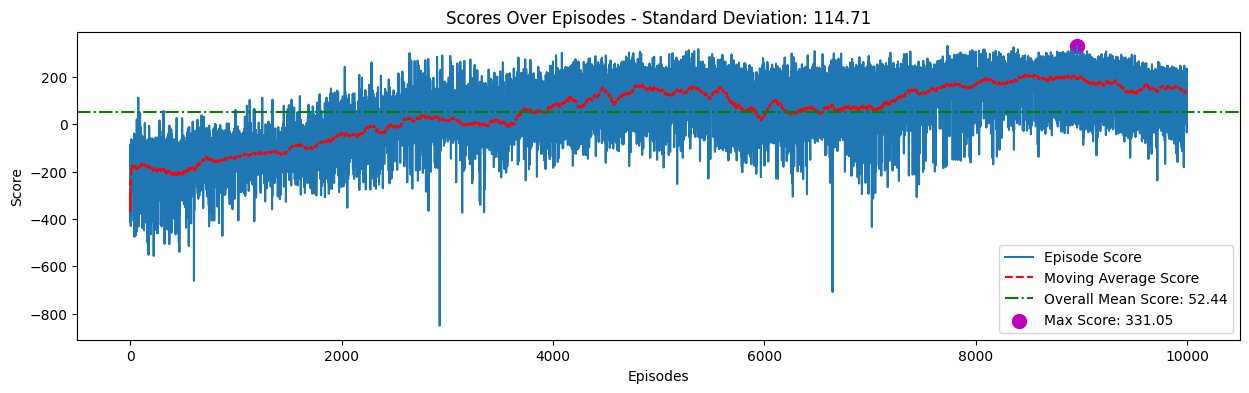

In [17]:
plot_score(score_hist, avg_score_hist, save_path=f'DQN_{n_hidden_units}layer_seed{seed}.png')

if str(device) == "cuda":
    torch.cuda.empty_cache()